In [2]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization
from keras.optimizers import adam_v2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date
import calendar
%matplotlib inline

In [3]:
df = pd.read_csv('grid.csv')

In [4]:
df['date'] = df.start_time.apply(lambda x: x.split()[0])
begin = datetime(2021, 3, 1)
df['day_in_period'] = df.date.apply(lambda x: (datetime.strptime(x, "%Y-%m-%d") - begin).days)
df['weekday'] = df.date.apply(lambda x: (date(int(x.split('-')[0]),int(x.split('-')[1]),int(x.split('-')[2])).weekday()+1)%7)

In [5]:
def grid_num(n,df):
    df=df[df['id']==n]
    count=df.groupby(['day_in_period','weekday']).size().reset_index(name='count')
    dummies = pd.get_dummies(count['weekday'], prefix='weekday', drop_first=False)
    count = pd.concat([count, dummies], axis=1)
    fields_to_drop = ['day_in_period', 'weekday']
    count = count.drop(fields_to_drop, axis=1)
    count.to_csv("Count_grid")

In [6]:
#数据颗粒度是小时, 时长1个月
n_in = 14 #历史数量, 168小时, 7天
n_out = 7 #预测数量, 预测未来一天
n_features = 8 #输入序列数
# n_test = 1
n_val = 1 #验证的数据量
n_epochs = 175 #迭代次数

In [7]:
#导入数据
def load_stw_data() -> pd.DataFrame:
    
    df_stw = pd.read_csv('Count_grid')
    df_stw = df_stw.drop('Unnamed: 0', axis=1)
    df_stw.columns = ['count_num','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6']
    return df_stw

In [8]:
#MinMaxScaler数据归一化，可以帮助网络模型更快的拟合，稍微有一些提高准确率的效果
def minmaxscaler(data: pd.DataFrame,scaler) -> pd.DataFrame:

    New_count = data.count_num.values
    New_count = New_count.reshape(len(New_count), 1)
    New_count = scaler.fit_transform(New_count) #fit_transform 函数比较严格, 所以要reshape, 单纯的list不可行
    New_count = New_count.reshape(len(New_count),)    
    data['count_num'] = New_count
        
    return data

In [9]:
#划分X和Y 几进几出: 进是x的维度, 出是y的维度
def build_train(train, n_in, n_out):
    
    # train = train.drop([" "], axis=1)
    X_train, Y_train = [], []
    for i in range(train.shape[0]-n_in-n_out+1):
        X_train.append(np.array(train.iloc[i:i+n_in]))
        Y_train.append(np.array(train.iloc[i+n_in:i+n_in+n_out]['count_num']))
        
    return np.array(X_train), np.array(Y_train) #最终返回两个数组

In [10]:
#划分训练数据集和验证数据集,这里需要注意的是我们需要预测的数据是不可以出现在训练中的，切记。
def split_data(x, y, n_test: int):
    
    x_train = x[:-n_val-n_out+1] #训练集 -n_out+1:这些数据会出现在验证中, 如果被训练过了, 验证就不准确了
    x_val = x[-n_val:]
    y_train = y[:-n_val-n_out+1] #验证集
    y_val = y[-n_val:] 
    
    return x_train, y_train, x_val, y_val

In [11]:
#构建LSTM
def build_lstm(n_in: int, n_features: int,x_train, y_train,x_val,y_val):
    
    model = Sequential()
    model.add(LSTM(15, activation='relu', input_shape=(n_in, n_features))) #注意输入的维度, 这是二维的 特征数量不一定为1
    model.add(Dropout(0.2)) #数据量比较少, 加入dropout可以稍微避免过拟合, 具体数值可以调参
    model.add(Dense(n_out)) #输出的维度要和y的维度一样
    model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])# 定义优化器和损失函数
    history=model.fit(x_train, y_train, epochs=n_epochs, batch_size=7,  verbose=1, validation_data=(x_val, y_val))
    #Batch Size：一次训练所选取的样本数(控制数据更新参数, 较大更能反应原数据整体情况,影响模型的优化程度和速度)。
    # verbose=1 训练的时候是否要展示训练过程 验证数据和训练数据的loss
    # validation_data 验证数据, 判断数据是欠拟合或者过拟合。如果验证数据的loss远大于训练数据, 说明模型可能过拟合了, 要早停或者调整模型
    model.optimizer.lr.assign(0.01)# 学习率
    
    return model,history

In [12]:
def plot_fig(predict,actual):
    x = [x for x in range(7)]
    fig, ax = plt.subplots(figsize=(15,5),dpi = 300)
    ax.plot(x, predict, linewidth=2.0,label = "predict")
    ax.plot(x, actual, linewidth=2.0,label = "actual")
    ax.legend(loc=2);
    # ax.set_title(bf_name)
    plt.grid(linestyle='-.')
    plt.show()

In [13]:
def accuracy_num(predict,actual):
    error = 0
    summery = 0
    for i in range(7):
        error += abs(predict[i] - actual[i])
        summery += actual[i]
    acc = 1 - error/summery
    return acc

In [14]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()


In [15]:
def grid_n(n):
    grid_num(n,df)
    #数据读取与归一化
    data = load_stw_data() 
    scaler = MinMaxScaler(feature_range=(0, 8))
    data = minmaxscaler(data,scaler)

    #数据划分
    data_copy = data.copy()
    x, y = build_train(data_copy, n_in, n_out)
    x_train, y_train, x_val, y_val = split_data(x, y, n_val)

    # 模型搭建和训练
    model,history = build_lstm(n_in,n_features,x_train, y_train,x_val,y_val)
    m = model.evaluate(x_val, y_val)
    predict = model.predict(x_val)  
    return predict,y_val,m,history,scaler

In [16]:
# 238 诺丁汉大学 人才公寓
predict,y_val,m,history,scaler=grid_n(238)
predict_validation = scaler.inverse_transform(predict)[0]
actual = scaler.inverse_transform(y_val)[0]
acc=accuracy_num(predict_validation,actual)

Epoch 1/175
1/1 [==============================] - 1s 1s/step - loss: 20.8986 - accuracy: 0.2500 - val_loss: 17.5045 - val_accuracy: 1.0000
Epoch 2/175
1/1 [==============================] - 0s 24ms/step - loss: 19.4343 - accuracy: 0.0000e+00 - val_loss: 17.6381 - val_accuracy: 1.0000
Epoch 3/175
1/1 [==============================] - 0s 29ms/step - loss: 20.1983 - accuracy: 0.0000e+00 - val_loss: 17.7624 - val_accuracy: 1.0000
Epoch 4/175
1/1 [==============================] - 0s 28ms/step - loss: 18.9104 - accuracy: 0.2500 - val_loss: 17.8817 - val_accuracy: 1.0000
Epoch 5/175
1/1 [==============================] - 0s 27ms/step - loss: 16.2890 - accuracy: 0.2500 - val_loss: 17.9816 - val_accuracy: 1.0000
Epoch 6/175
1/1 [==============================] - 0s 26ms/step - loss: 18.2560 - accuracy: 0.2500 - val_loss: 18.0828 - val_accuracy: 1.0000
Epoch 7/175
1/1 [==============================] - 0s 27ms/step - loss: 18.3108 - accuracy: 0.2500 - val_loss: 18.1786 - val_accuracy: 1.0000


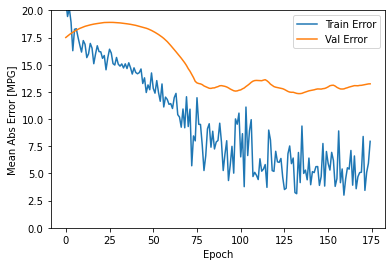

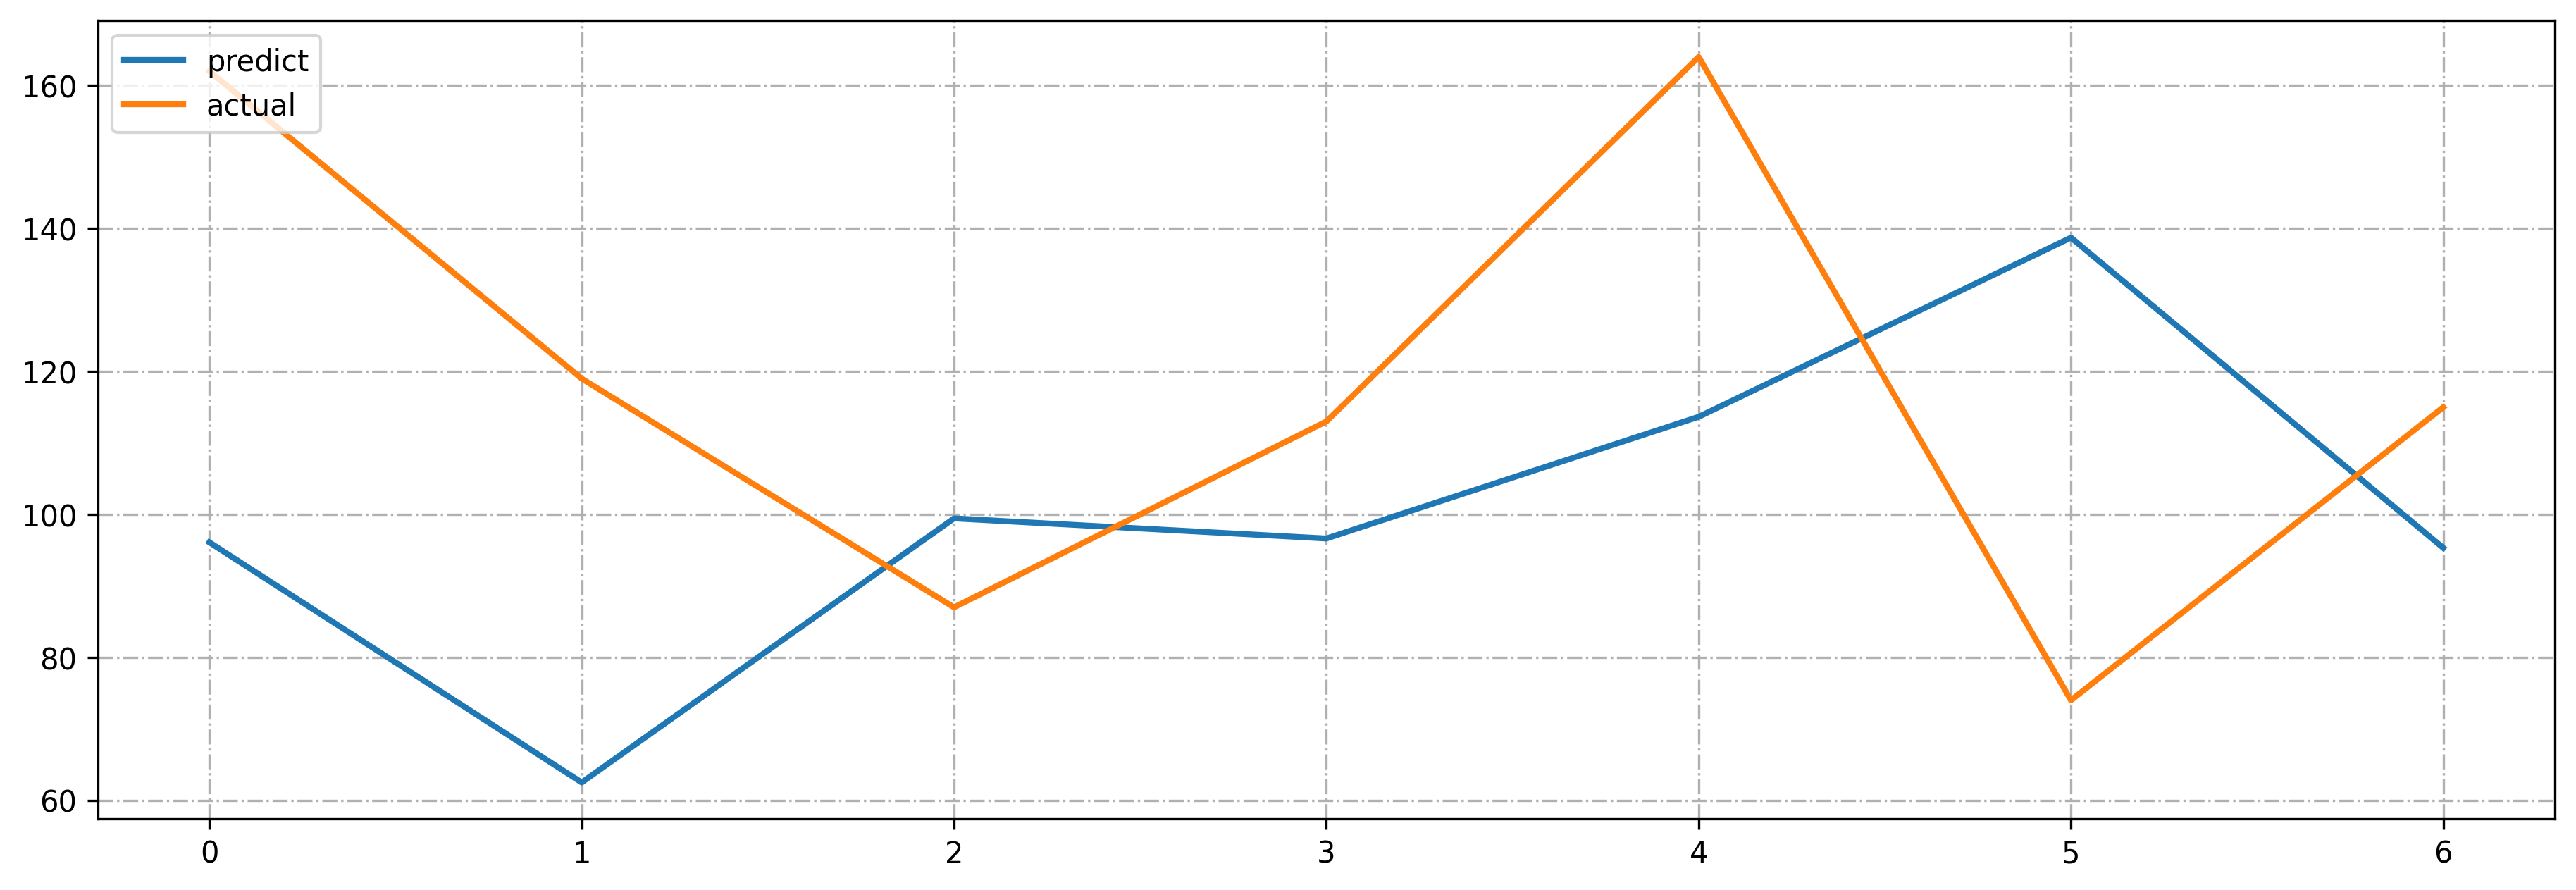

13.243131637573242 0.6571082108312374


In [17]:
plot_history(history)
plot_fig(predict_validation,actual)
print(m[0],acc)

In [18]:
# 425 万里学院
predict,y_val,m,history,scaler=grid_n(425)
predict_validation = scaler.inverse_transform(predict)[0]
actual = scaler.inverse_transform(y_val)[0]
acc=accuracy_num(predict_validation,actual)

Epoch 1/175
1/1 [==============================] - 1s 1s/step - loss: 22.7917 - accuracy: 0.2500 - val_loss: 20.9085 - val_accuracy: 1.0000
Epoch 2/175
1/1 [==============================] - 0s 27ms/step - loss: 22.8875 - accuracy: 0.2500 - val_loss: 20.7648 - val_accuracy: 1.0000
Epoch 3/175
1/1 [==============================] - 0s 28ms/step - loss: 22.5663 - accuracy: 0.2500 - val_loss: 20.6248 - val_accuracy: 1.0000
Epoch 4/175
1/1 [==============================] - 0s 28ms/step - loss: 22.0578 - accuracy: 0.2500 - val_loss: 20.4915 - val_accuracy: 1.0000
Epoch 5/175
1/1 [==============================] - 0s 28ms/step - loss: 21.3941 - accuracy: 0.2500 - val_loss: 20.3659 - val_accuracy: 1.0000
Epoch 6/175
1/1 [==============================] - 0s 30ms/step - loss: 21.7842 - accuracy: 0.2500 - val_loss: 20.2412 - val_accuracy: 1.0000
Epoch 7/175
1/1 [==============================] - 0s 30ms/step - loss: 21.8752 - accuracy: 0.2500 - val_loss: 20.1188 - val_accuracy: 1.0000
Epoch 8/

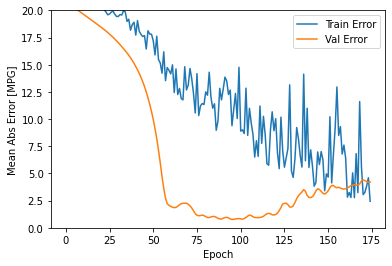

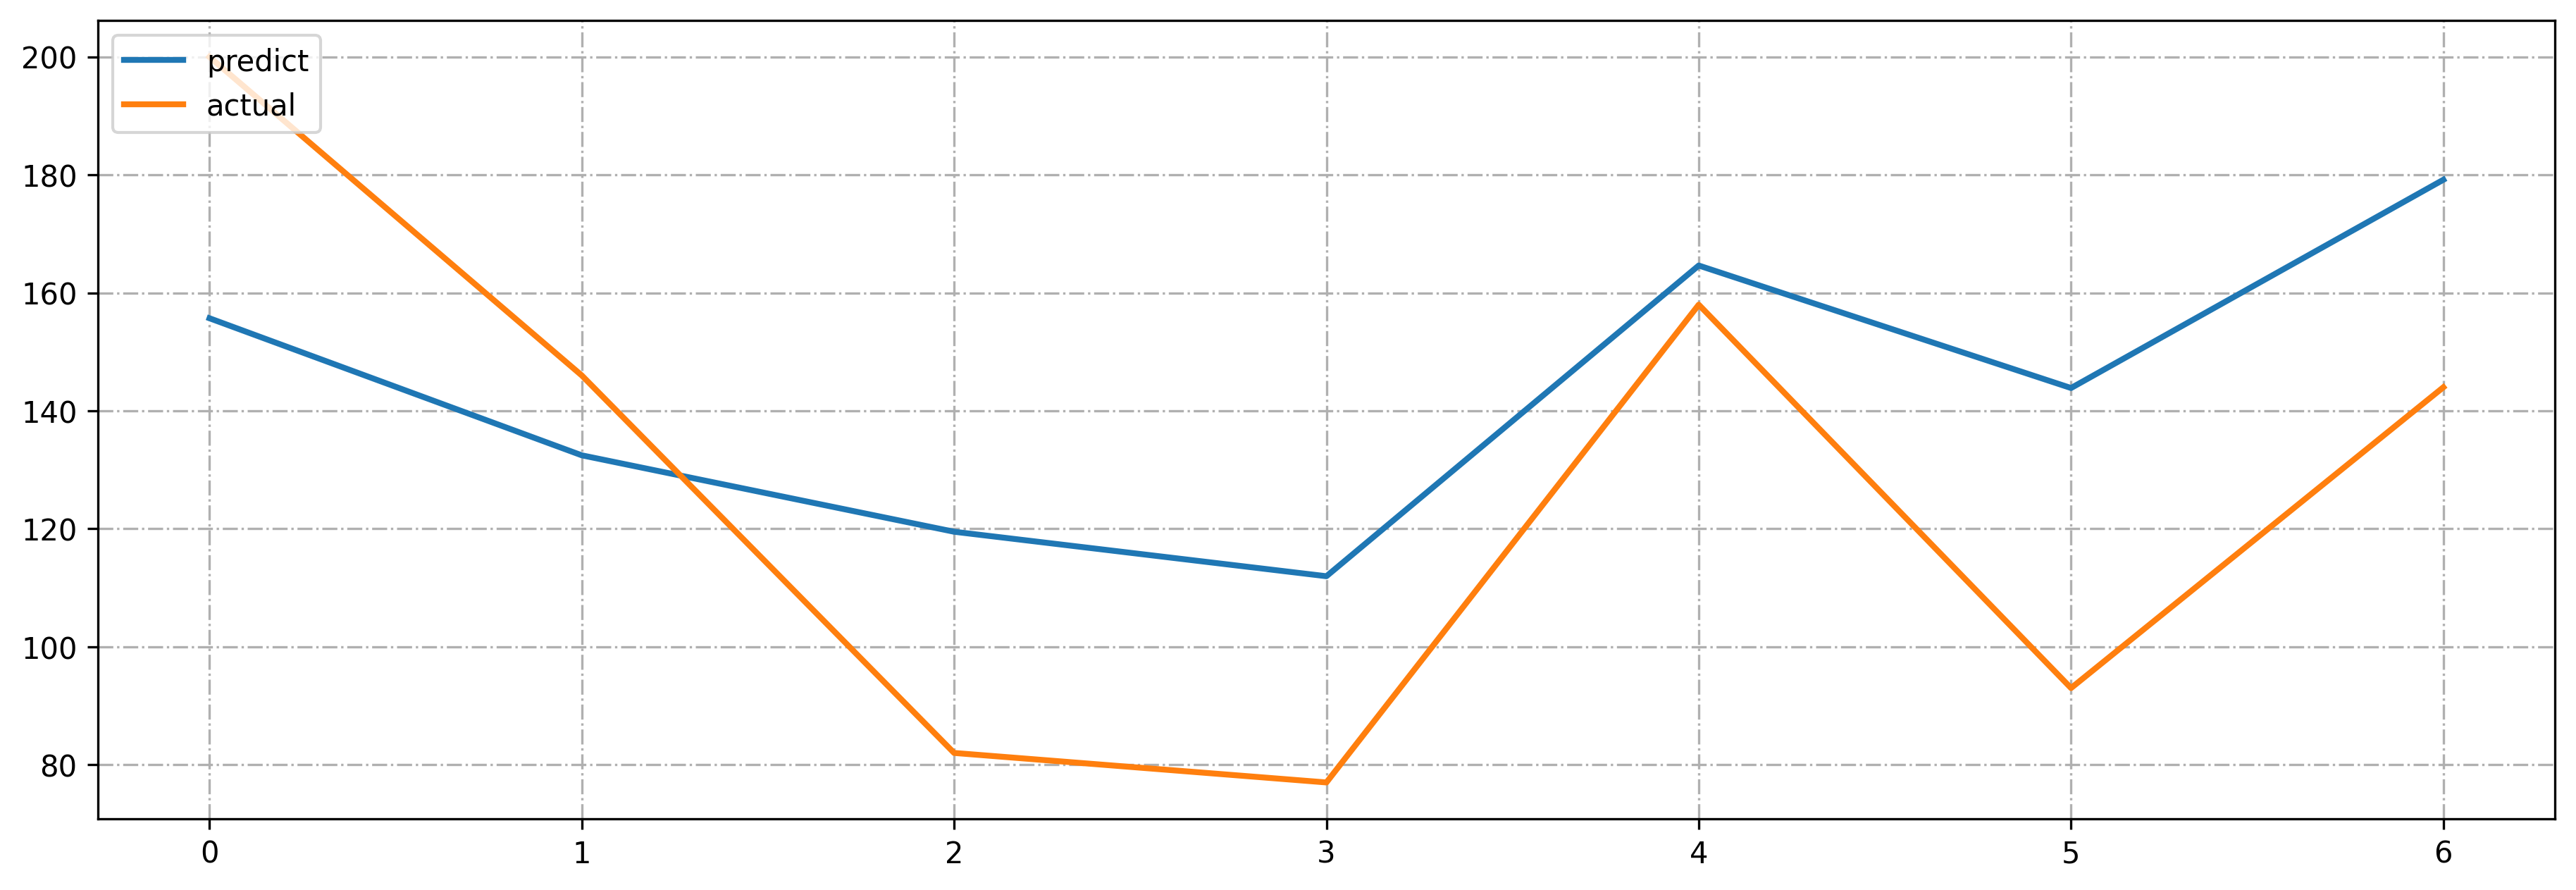

4.210808277130127 0.7522273678249782


In [19]:
plot_history(history)
plot_fig(predict_validation,actual)
print(m[0],acc)

In [20]:
# 科技孵化园 322
predict,y_val,m,history,scaler=grid_n(322)
predict_validation = scaler.inverse_transform(predict)[0]
actual = scaler.inverse_transform(y_val)[0]
acc=accuracy_num(predict_validation,actual)

Epoch 1/175
1/1 [==============================] - 1s 1s/step - loss: 25.4886 - accuracy: 0.0000e+00 - val_loss: 27.0266 - val_accuracy: 0.0000e+00
Epoch 2/175
1/1 [==============================] - 0s 28ms/step - loss: 25.3447 - accuracy: 0.0000e+00 - val_loss: 26.7589 - val_accuracy: 0.0000e+00
Epoch 3/175
1/1 [==============================] - 0s 25ms/step - loss: 24.4494 - accuracy: 0.0000e+00 - val_loss: 26.4998 - val_accuracy: 0.0000e+00
Epoch 4/175
1/1 [==============================] - 0s 24ms/step - loss: 25.7988 - accuracy: 0.0000e+00 - val_loss: 26.2445 - val_accuracy: 0.0000e+00
Epoch 5/175
1/1 [==============================] - 0s 27ms/step - loss: 24.8713 - accuracy: 0.0000e+00 - val_loss: 25.9973 - val_accuracy: 0.0000e+00
Epoch 6/175
1/1 [==============================] - 0s 24ms/step - loss: 24.2715 - accuracy: 0.2500 - val_loss: 25.7693 - val_accuracy: 0.0000e+00
Epoch 7/175
1/1 [==============================] - 0s 24ms/step - loss: 23.6598 - accuracy: 0.2500 - val_l

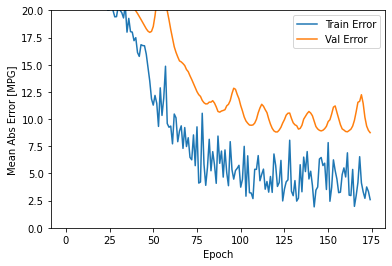

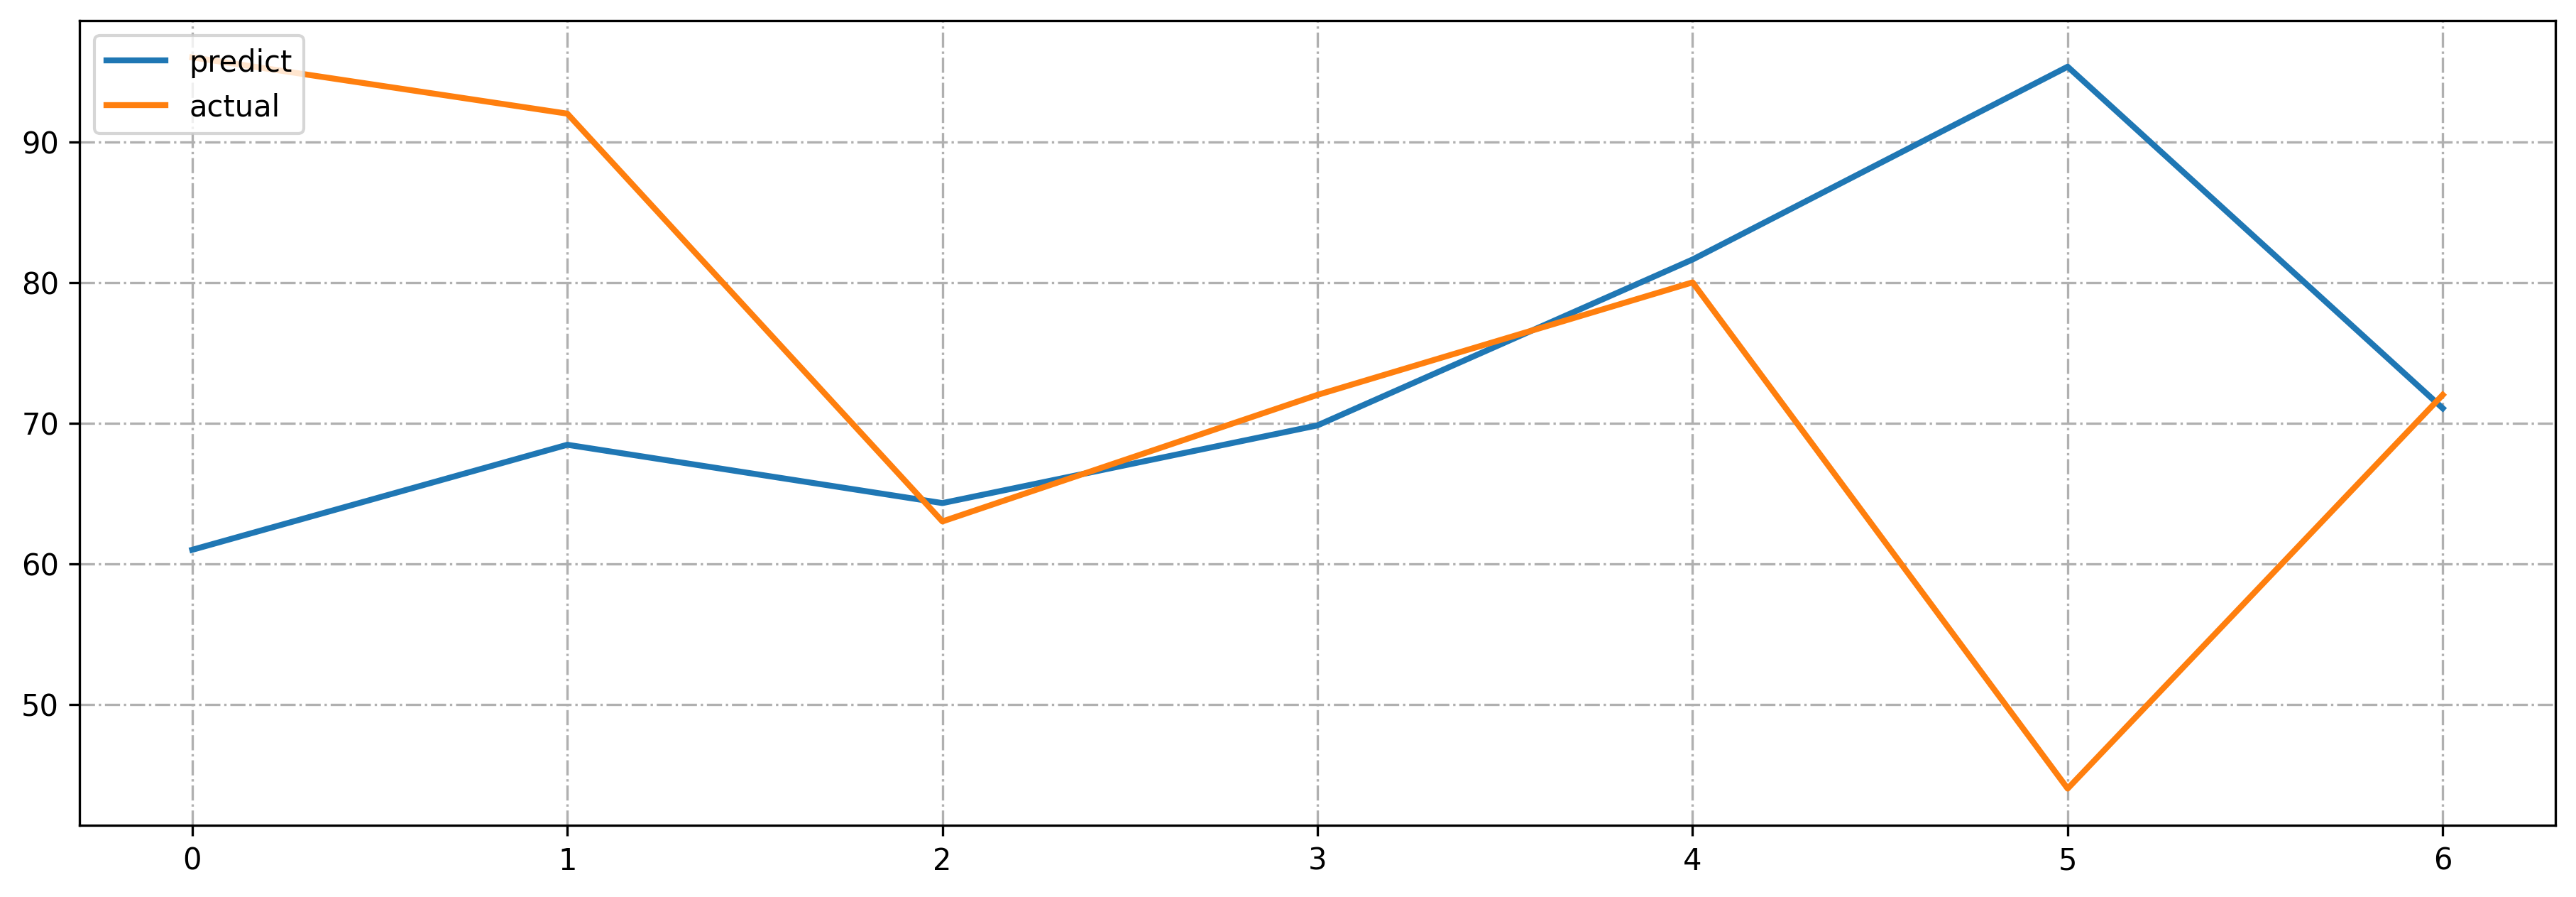

8.751923561096191 0.7765759227363132


In [21]:
plot_history(history)
plot_fig(predict_validation,actual)
print(m[0],acc)